# BH score

This is a demo script reproducing the main results of [Nonaka et al. (2021) Brain hierarchy score: Which deep neural networks are hierarchically brain-like?. *iScience*](http://dx.doi.org/10.1016/j.isci.2021.103013).

In [1]:
import os
import json
from itertools import product

import numpy as np
import hdf5storage
import matplotlib.pyplot as plt

from bhscore import compute_bhscore, compute_bhscore_layerselect

In [2]:
# Settings
with open('settings.json', 'r') as f:
    settings = json.load(f)

networks = settings['dnns']

subjects = settings['subjects']
rois = settings['rois']

decoding_accuracy_dir = './data/decoding_accuracy/ImageNetTest'
encoding_accuracy_dir = './data/encoding_accuracy/ImageNetTest'

In [3]:
# Load decoding accuracy
decoding_accuracy = {}

for net_name, net in networks.items():
    layers = net['layers']
    acc_net = []

    for lay in layers:
        acc_layer = []  # This should be a 2-d array of ROIs x units.

        for roi in rois:
            acc_roi = []

            # Pool decoding accuracies across subjects
            for sub in subjects:
                acc_file = os.path.join(decoding_accuracy_dir, net['dir'], lay, sub, roi, 'accuracy.mat')
                acc = hdf5storage.loadmat(acc_file)['accuracy'].flatten()
                acc_roi.append(acc)
            acc_roi = np.hstack(acc_roi)
            acc_layer.append(acc_roi)

        acc_layer = np.vstack(acc_layer)
        acc_net.append(acc_layer)

    decoding_accuracy.update({net_name: acc_net})

In [4]:
# Calculate decoding-based BH scores
bh_scores_dec = {}

for net in networks:
    bh_score = np.mean(compute_bhscore_layerselect(decoding_accuracy[net], pval=0.05, n_layers=5, n_repeat=100))
    bh_scores_dec.update({net: bh_score})
    print('{}: {}'.format(net, bh_score))

AlexNet: 0.4928224368861789
VGG-F: 0.511309960547578
VGG-M: 0.5188937319034099
VGG-S: 0.5367787736852041
VGG-16: 0.4509592981190411
VGG-19: 0.47820033850373683
DenseNet-121: 0.4057783214720542
DenseNet-161: 0.39798536584614624
DenseNet-169: 0.38280530460561585
DenseNet-201: 0.4050069285978119
ResNet-50-v2: 0.17874310888687045
ResNet-101-v2: 0.14758564520655
ResNet-152-v2: 0.13765118762888953
ResNet-18: 0.43566789542183243
ResNet-34: 0.40799275231891025
Inception-v1: 0.2626805749364008
Inception-v2: 0.2428201761957668
Inception-v3: 0.04675912334800784
Inception-v4: 0.03877159379105938
Inception-ResNet-v2: 0.18935473861142704
SqueezeNet-1.0: 0.4679142153358977
SqueezeNet-1.1: 0.3806511376248982
NASNet-Mobile: 0.2019286905798524
NASNet-Large: 0.07249763774156266
PNASNet-Large: 0.17975438083252485
CORnet-Z: 0.2958043016744105
CORnet-R: 0.45847121344734754
CORnet-S: 0.4468106311786503
MobileNet-v2-1.4-224: 0.20157053453816953


In [5]:
# Load encoding accuracy
encoding_accuracy = {}

for net_name, net in networks.items():
    layers = net['layers']
    acc_net = []

    for roi in rois:
        acc_roi = []  # This should be a 2-d array of layers x voxels.

        for lay in layers:
            acc_layer = []

            # Pool encoding accuracies across subjects
            for sub in subjects:
                acc_file = os.path.join(encoding_accuracy_dir, net['dir'], lay, sub, roi, 'accuracy.mat')
                acc = hdf5storage.loadmat(acc_file)['accuracy'].flatten()
                # Select random 1000 voxels
                if len(acc) > 1000:
                    np.random.seed(0)
                    acc = np.random.choice(acc, size=1000, replace=False)
                acc_layer.append(acc)
            acc_layer = np.hstack(acc_layer)
            acc_roi.append(acc_layer)

        acc_roi = np.vstack(acc_roi)
        acc_net.append(acc_roi)

    encoding_accuracy.update({net_name: acc_net})

In [6]:
# Calculate encoding-based BH scores
bh_scores_enc = {}

for net in networks:
    bh_score = compute_bhscore(encoding_accuracy[net], pval=0.05)
    bh_scores_enc.update({net: bh_score})
    print('{}: {}'.format(net, bh_score))

AlexNet: 0.3396893846667241
VGG-F: 0.3335122643467014
VGG-M: 0.3007579433882166
VGG-S: 0.33320771565774904
VGG-16: 0.3140827277486492
VGG-19: 0.32501573437023884
DenseNet-121: 0.15816601201758074
DenseNet-161: 0.16397250480947376
DenseNet-169: 0.1600756833177794
DenseNet-201: 0.15055057054874896
ResNet-50-v2: 0.20777355640726555
ResNet-101-v2: 0.17974705887953604
ResNet-152-v2: 0.14762296798275332
ResNet-18: 0.3206887139165882
ResNet-34: 0.3340086174537223
Inception-v1: 0.25217374872152204
Inception-v2: 0.23768792967484945
Inception-v3: 0.2421976212996117
Inception-v4: 0.16667742438955932
Inception-ResNet-v2: 0.23925634379791547
SqueezeNet-1.0: 0.20261743947153588
SqueezeNet-1.1: 0.22346374692755167
NASNet-Mobile: 0.22503197624663188
NASNet-Large: 0.2557132655937244
PNASNet-Large: 0.2389122764848542
CORnet-Z: 0.23301553581150353
CORnet-R: 0.38734730471436357
CORnet-S: 0.306205341770931
MobileNet-v2-1.4-224: 0.20544614317742066


In [7]:
# Calculate averaged BH scores
bh_scores = {}

for net in networks:
    bh_score = np.mean([bh_scores_dec[net], bh_scores_enc[net]])
    bh_scores.update({net: bh_score})
    print('{}: {}'.format(net, bh_score))

AlexNet: 0.4162559107764515
VGG-F: 0.4224111124471397
VGG-M: 0.40982583764581326
VGG-S: 0.4349932446714766
VGG-16: 0.38252101293384516
VGG-19: 0.40160803643698784
DenseNet-121: 0.2819721667448175
DenseNet-161: 0.28097893532781
DenseNet-169: 0.2714404939616976
DenseNet-201: 0.2777787495732804
ResNet-50-v2: 0.193258332647068
ResNet-101-v2: 0.16366635204304303
ResNet-152-v2: 0.1426370778058214
ResNet-18: 0.3781783046692103
ResNet-34: 0.37100068488631627
Inception-v1: 0.2574271618289614
Inception-v2: 0.2402540529353081
Inception-v3: 0.14447837232380978
Inception-v4: 0.10272450909030935
Inception-ResNet-v2: 0.21430554120467127
SqueezeNet-1.0: 0.3352658274037168
SqueezeNet-1.1: 0.30205744227622494
NASNet-Mobile: 0.21348033341324213
NASNet-Large: 0.16410545166764354
PNASNet-Large: 0.20933332865868953
CORnet-Z: 0.26440991874295705
CORnet-R: 0.4229092590808555
CORnet-S: 0.37650798647479067
MobileNet-v2-1.4-224: 0.2035083388577951


VGG-S: 0.4349932446714766
CORnet-R: 0.4229092590808555
VGG-F: 0.4224111124471397
AlexNet: 0.4162559107764515
VGG-M: 0.40982583764581326
VGG-19: 0.40160803643698784
VGG-16: 0.38252101293384516
ResNet-18: 0.3781783046692103
CORnet-S: 0.37650798647479067
ResNet-34: 0.37100068488631627
SqueezeNet-1.0: 0.3352658274037168
SqueezeNet-1.1: 0.30205744227622494
DenseNet-121: 0.2819721667448175
DenseNet-161: 0.28097893532781
DenseNet-201: 0.2777787495732804
DenseNet-169: 0.2714404939616976
CORnet-Z: 0.26440991874295705
Inception-v1: 0.2574271618289614
Inception-v2: 0.2402540529353081
Inception-ResNet-v2: 0.21430554120467127
NASNet-Mobile: 0.21348033341324213
PNASNet-Large: 0.20933332865868953
MobileNet-v2-1.4-224: 0.2035083388577951
ResNet-50-v2: 0.193258332647068
NASNet-Large: 0.16410545166764354
ResNet-101-v2: 0.16366635204304303
Inception-v3: 0.14447837232380978
ResNet-152-v2: 0.1426370778058214
Inception-v4: 0.10272450909030935


([], [])

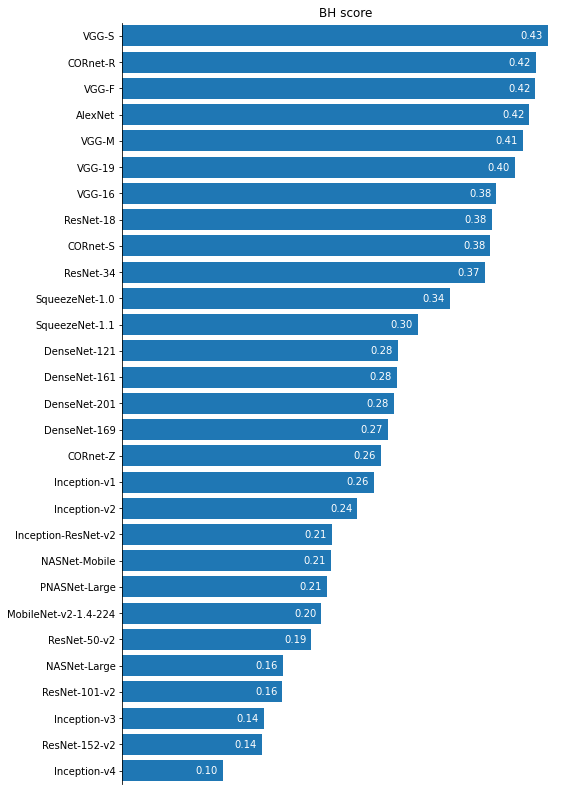

In [8]:
# Display BH score ranking (Figure 3)

nets = np.array([n for n in bh_scores.keys()])
bhscores = np.array([s for s in bh_scores.values()])

ranking_index = np.argsort(bhscores)[::-1]
nets = nets[ranking_index]
bhscores = bhscores[ranking_index]

for net, bhscore in zip(nets, bhscores):
    print('{}: {}'.format(net, bhscore))

# Bar chart

fig = plt.figure(figsize=(8, 14))

ypos = range(nets.shape[0])[::-1]

plt.barh(ypos, bhscores)

plt.title('BH score')

plt.yticks(ypos, nets)
plt.ylim([-0.5, nets.shape[0] - 0.5])

for yp, bhs in zip(ypos, bhscores):
    plt.text(bhs - 0.005, yp, '%.2f' % bhs, color='white',
             horizontalalignment='right',
             verticalalignment='center')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.xticks([])